### #01. 준비작업
---

In [13]:
#라이브러리 기본 참조
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame, get_dummies

#로지스틱을 위한 참조
import statsmodels.api as sm

#로지스틱 결과 판별을 위한 참조
# -> 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# VIF 값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### 2. 그래프 초기화

In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

#### 3. 데이터 가져오기

In [3]:
origin = load_data('pima_indians_diabetes')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/pima_indians_diabetes.xlsx
[desc] 이 데이터 세트는 원래 미국 국립 당뇨병·소화기·신장질환 연구소(National Institute of Diabetes and Digestive and Kidney Diseases)에서 제공한 것입니다. 이 데이터 세트의 목적은 데이터 세트에 포함된 특정 진단 측정값을 기반으로 환자의 당뇨병 여부를 진단적으로 예측하는 것입니다. 더 큰 데이터베이스에서 이러한 사례를 선택하는 데에는 몇 가지 제약 조건이 적용되었습니다. 특히, 여기에 포함된 모든 환자는 21세 이상의 피마 인디언 혈통을 가진 여성입니다. (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

field                     type    description
------------------------  ------  --------------------------------
Pregnancies               연속형  임신횟수
Glucose                   연속형  포도당 부하 검사 수치
BloodPressure             연속형  혈압
SkinThickness             연속형  팔 삼두근 뒤쪽의 피하지방 측정값
Insulin                   연속형  혈청 인슐린
BMI                       연속형  체질량 지수
DiabetesPedigreeFunction  연속형  당뇨 내력 가중치 값
Age                       연속형  나이
Outcome                   명목형  당뇨여부(0 또는 1)


===== 데이터 크기 확인 =====
데이터셋 크기 : (768, 9)
열 개수: 9
행 개수: 768

===== 데이터 타입 확인 =====
<class

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### #02. 기본분석
---
전처리 없이 분류모형 구축

#### 1. 모델 구축

In [14]:
yname = 'Outcome'                   #종속변수 이름

x = origin.drop(yname, axis=1)      #독립변수만 추출(DataFrame)
y = origin[yname]                   #종속변수만 추출(Series)

x_input = sm.add_constant(x)        #독립변수에 상수항 추가

fit = sm.Logit(y, x_input).fit()
tbl1=fit.summary()
print(tbl1)

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                   화, 16 12 2025   Pseudo R-squ.:                  0.2718
Time:                        10:45:37   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.4047      0.717    -11.728      0.000      -9.809

#### 2. 결과보고 함수 정의
---

In [15]:
def logit_report(fit, data, threshold=0.5):
    """
    Logit summary(tbl)와 데이터프레임(data)을 받아
    회귀계수 표(rdf),
    모델 적합도 요약(result_report),
    모형보고문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    """
    #-----------------------
    #성능 평가 지표
    #-----------------------
    yname = fit.model.endog_names       
    y_true = data[yname]
    y_pred= fit.predict(fit.model.exog)
    y_pred_fix = (y_pred >= threshold).astype(int)

    #혼동 행렬
    cm = confusion_matrix(y_true, y_pred_fix)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true, y_pred_fix)            #정확도
    pre = precision_score(y_true, y_pred_fix)           #정밀도
    tpr = recall_score(y_true, y_pred_fix)              #재현율(민감도)
    fpr = fp/(fp + tn)                                  #위양성율
    tnr = 1-fpr                                         #특이성
    f1 = f1_score(y_true, y_pred_fix)                   #f1-score
    ras = roc_auc_score(y_true, y_pred)                 #auc score

    cdf = DataFrame({
        '설명력(P-Rsqe)': [fit.prsquared],
        '정확도(Accuracy)': [acc],
        '정밀도(Precision)': [pre],
        '재현율(Recall)': [tpr],
        '위양성율(Fallout,FPR)': [fpr],
        '특이성(Specificity, TNR)': [tnr],
        'RAS(auc score)': [ras],
        'F1': [f1]
    })

    #-----------------------
    #회귀계수 표
    #-----------------------

    tbl = fit.summary()

    #종속변수 이름
    yname = fit.model.endog_names

    #독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    #독립변수
    x = data[xnames]

    variables = []

    # VIF 계산
    vif_dict = {
        col:variance_inflation_factor(x.values, i)
        for i, col in enumerate(x.columns)
    }

    for v in tbl.tables[1].data:
        name = v[0].strip()
        if name not in xnames:
            continue

        beta = float(v[1])
        se = float(v[2])
        z = float(v[3])
        p = float(v[4])

        or_val = np.exp(beta)
        ci_low = np.exp(beta - 1.96 * se)
        ci_high = np.exp(beta + 1.96 * se)

        stars = (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B(베타)" :beta,
            "표준오차": se,
            "z": f"{z:.3f}{stars}",
            "p-value": p,
            "OR": or_val,
            "CI_lower": ci_low,
            "CI_upper": ci_high,
            "VIF": vif_dict.get(name,np.nan)
        })

    rdf = DataFrame(variables)

    y_true = data[yname]
    y_prob= fit.predict(fit.model.exog)
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc= accuracy_score(y_true, y_pred)
    pre= precision_score(y_true, y_pred)
    rec= recall_score(y_true, y_pred)
    f1= f1_score(y_true, y_pred)
    auc= roc_auc_score(y_true, y_prob)

    result_report=(
        f"Pseudo R-squared: {fit.prsquared:.3f}, "
        f"LLR X^2({int(fit.df_model)})={fit.llr:.3f}, "
        f"p-value={fit.llr_pvalue:.4f}, "
        f"Accuracy: {acc:.3f}, "
        f"AUC: {auc:.3f}"
    )


    #-----------------------
    #모형보고 문장 작성
    #----------------------

    tpl = (
        "%s에 대하여 %s로 예측하는 로지스틱 회귀분석을 실시한 결과, "
        "모형은 통계적으로 %s(X^2(%s) = %.3f, p %s 0.05)하였다."
    )

    model_report = tpl % (
        yname,
        ", ".join(xnames),
        "유의" if fit.llr_pvalue <= 0.05 else "유의하지 않음",
        int(fit.df_model),
        fit.llr,
        "<=" if fit.llr_pvalue <= 0.05 else ">"
    )

    #-----------------------
    #변수별 보고 문장 작성
    #-----------------------
    
    variable_reports = []

    s=(
        "%s의 오즈비는 %.3f(p %s 0.05)로, "
        "%s 발생 odds에 %s 영향을 미치는 것으로 나타났다."
    )

    for _, row in rdf.iterrows():
        variable_reports.append(
            s % (
                row['독립변수'],
                row["OR"],
                "<=" if row['p-value'] < 0.05 else ">",
                row['종속변수'],
                "유의미한" if row['p-value'] < 0.05 else "유의하지 않은"
            )
        )
    return cdf, rdf, result_report, model_report, variable_reports

#### 3. 분석결과 보고

In [7]:
cdf,rdf,r,m,v = logit_report(fit, origin)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),재현율(Recall),"위양성율(Fallout,FPR)","특이성(Specificity, TNR)",RAS(auc score),F1
0,0.27181,0.782552,0.739336,0.58209,0.11,0.89,0.839425,0.651357


,종속변수,독립변수,B(베타),표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,Pregnancies,0.1232,0.032,3.840***,0.000,1.131111,1.062346,1.204326,3.275748
1,Outcome,Glucose,0.0352,0.004,9.481***,0.000,1.035827,1.027738,1.043980,16.725078
2,Outcome,BloodPressure,-0.0133,0.005,-2.540*,0.011,0.986788,0.977165,0.996506,14.619512
3,Outcome,SkinThickness,0.0006,0.007,0.090,0.929,1.000600,0.986966,1.014423,4.008696
4,Outcome,Insulin,-0.0012,0.001,-1.322,0.186,0.998801,0.996845,1.000760,2.063689
5,Outcome,BMI,0.0897,0.015,5.945***,0.000,1.093846,1.062155,1.126483,18.408884
6,Outcome,DiabetesPedigreeFunction,0.9452,0.299,3.160**,0.002,2.573328,1.432126,4.623907,3.195626
7,Outcome,Age,0.0149,0.009,1.593,0.111,1.015012,0.997264,1.033075,13.492985


'Pseudo R-squared: 0.272, LLR X^2(8)=270.039, p-value=0.0000, Accuracy: 0.783, AUC: 0.839'

'Outcome에 대하여 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의(X^2(8) = 270.039, p <= 0.05)하였다.'

['Pregnancies의 오즈비는 1.131(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Glucose의 오즈비는 1.036(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'BloodPressure의 오즈비는 0.987(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'SkinThickness의 오즈비는 1.001(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'Insulin의 오즈비는 0.999(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'BMI의 오즈비는 1.094(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'DiabetesPedigreeFunction의 오즈비는 2.573(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Age의 오즈비는 1.015(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.']

#### 4. AUC 시각화

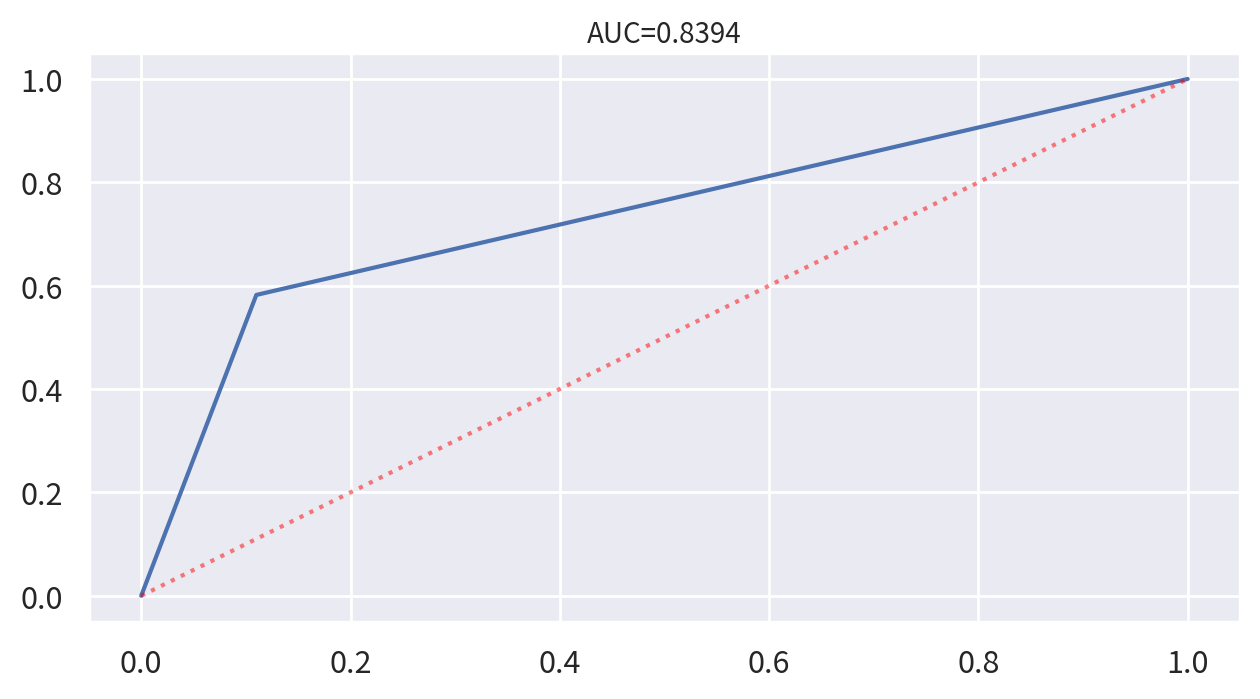

In [9]:
y_true = origin[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)

ras = roc_auc_score(y_true, y_prob)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 720             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
ax.grid(True)
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

### #02. 독립변수 로그 변환
---
#### 1. 로그변환 후 다시 분석

In [11]:
df = origin.copy()

yname = "Outcome"
y = df[yname]
x = df.drop(yname, axis=1)

log_vars = x.columns

for v in log_vars:
    df[f"log_{v}"] = np.log1p(df[v])

df.drop(columns = log_vars, inplace=True)

X_log = df.drop(columns=[yname])
X_input = sm.add_constant(X_log)

fit = sm.Logit(y, X_input).fit()
print(fit.summary())



Optimization terminated successfully.
         Current function value: 0.516943
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                   화, 16 12 2025   Pseudo R-squ.:                  0.2008
Time:                        10:41:30   Log-Likelihood:                -397.01
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 8.305e-39
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -25.6571      2.490    -10.303      0.000

#### 2. AUC 시각화

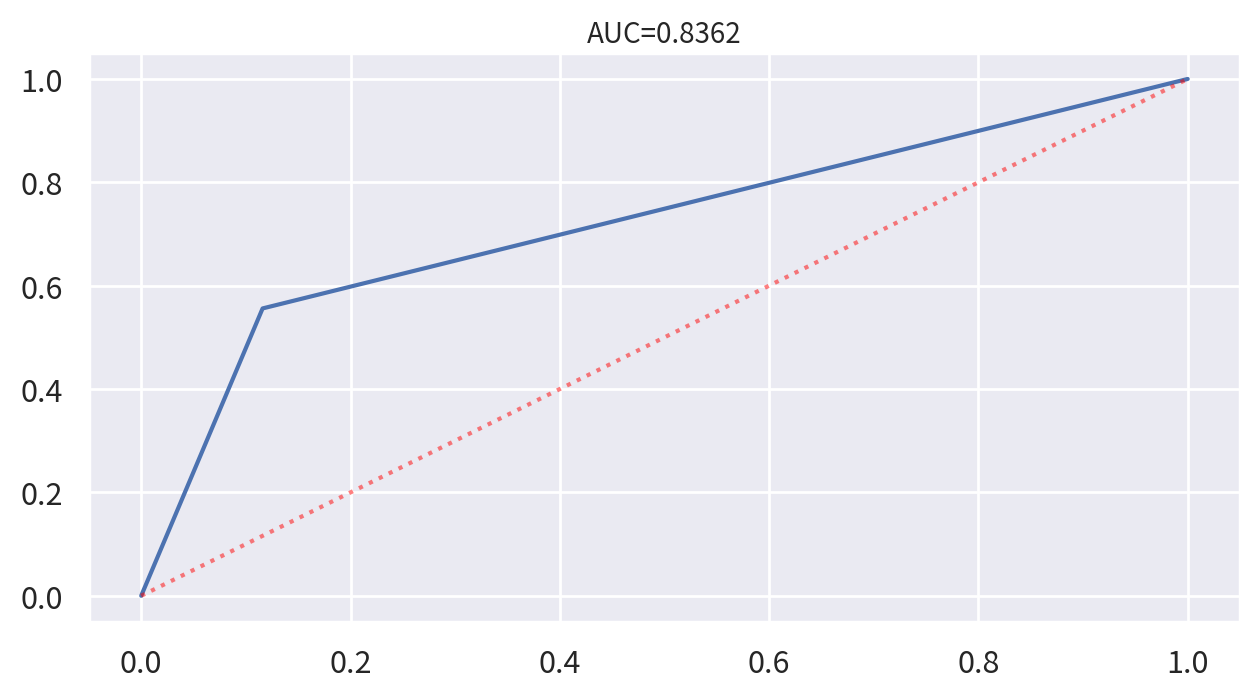

In [12]:
y_true = df[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)

ras = roc_auc_score(y_true, y_prob)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 720             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)
# 2) 그래프 그리기 -> seaborn 사용
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
ax.grid(True)
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)
# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료
